In [1]:
from matplotlib import pyplot as plt
import koreanize_matplotlib
import pandas as pd
import seaborn as sns
import numpy as np
import os

def get_file_paths(in_dir: str, inner_flag: bool) :
    file_paths = []

    if inner_flag :
        for (parent_path, dirs, file_names) in os.walk(in_dir) :
                for file_name in file_names :
                    file_path = os.path.join(parent_path, file_name)

                    if os.path.isfile(file_path) :
                        file_paths.append(file_path)
    else :
        file_names = os.listdir(in_dir)
        for file_name in file_names :
            file_path = os.path.join(in_dir, file_name)

            if os.path.isfile(file_path) :
                file_paths.append(file_path)

    return file_paths

def get_file_name(file_path: str, rm_ext_flag=False):
    file_name = os.path.basename(file_path)
    
    if rm_ext_flag:
        idx = file_name.rfind('.')
        
        if idx != -1:
            file_name = file_name[:idx]
    
    return file_name

def make_parent(file_path: str) :
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

def open_file(file_path: str, encoding: str, mode: str) :
    if mode == 'w' :
        make_parent(file_path)

    if len(encoding) == 0 :
        return open(file_path, mode)
    else :
        return open(file_path, mode, encoding=encoding)
    
def to_numeric(data):
    if (data.name != '시도') and (data.dtype == object):
        data = pd.Series([int(str(x).replace(',', '')) for x in data])
    return data


import hospital_condition_file

In [2]:

'''
    Data_1. 2019_1 ~ 2023_1 분기의 전국 지역별 병원 현황 데이터 import
'''
# hos_files : 2019_1 ~ 2023_1 분기의 전국 지역별 병원 현황 데이터의 데이터 프레임을 담은 list
# 병원 현황 DataFrame 형식 : df_2019_1

hos_files = []
file_paths = get_file_paths('./src/hospital_condition/', True)
for file_path in file_paths:
    file_name = get_file_name(file_path, False)
    year = file_name[2:4] + '_' + file_name[5]
    locals()['df_'+year] = pd.read_excel(file_path, header=6)
    hos_files.append(locals()['df_'+year])

print('다운받은 전국 지역별 병원 현황 데이터 :', len(hos_files))


'''
    Data_2. 2019_1 ~ 2023_1 분기의 전국 지역별 병원 현황 데이터를
       지역별로 분리
'''
# sido_hos_files : 지역별 병원 현황을 2019_1 ~ 2023_1 분기 순서로 담은 데이터 프레임이 담긴 list
# sido_files     : 위의 리스트의 데이터를 시도을 제외하고 수치형 데이터로 바꾸어 dict 형식으로 저장.
#                   데이터프레임 이름 : 데이터 프레임 파일
# 병원 현황 DataFrame 형식 : df_2019_1

sido_hos_files = []
hos_files_len = len(hos_files[0])
for i in range(hos_files_len):
    sido = df_19_1.시도.iloc[i]
    for j in range(len(hos_files)):
        if j == 0:
            sido_df = pd.DataFrame(hos_files[j].iloc[i]).T
        else:
            sido_df = pd.concat([sido_df, pd.DataFrame(hos_files[j].iloc[i]).T], ignore_index=True)

    # 데이터 결측치 처리 :수치형 데이터 이므로 모두 0으로 처리
    sido_df = sido_df.replace('-', 0)
    locals()['df_sido_'+sido] = sido_df.fillna(0)
    sido_hos_files.append(locals()['df_sido_'+sido])

sido_files = {}
for sidofile in sido_hos_files:
    name = sidofile['시도'][0]
    sido_files['sido_'+ name] =sidofile.apply(to_numeric, axis = 0)

sido_files['sido_계']['시도'] = '전국'


'''
    Data_3. 2019 ~ 2022 전국 인구 데이터를 지역별로 수집
'''
# popul : 한 개 파일에 2019 ~ 2022 전체 데이터가 들어있음
# popul_files : 연도별 인구데이터가 들어있음.
# young_popul_files : 연도별 0~9세, 10~19세, 0~19세 인구 수의 데이터가 들어있음
# young_popul_local : 지역별로 연도 순으로  0~9세, 10~19세, 0~19세 인구 수의 데이터가 dict 형태로 들어있음.

popul = pd.read_csv('./src/201912_202212_연령별인구현황_연간.csv', encoding='euc-kr', index_col= 0)
popul_indexes = [x[:2] if x[:2] not in ['충청', '전라', '경상'] else x[0] + x[2] for x in popul.index]
popul = popul.apply(to_numeric)
popul.index = popul_indexes

year = 2019
popul_files = []
for i in range(0, len(popul.columns), 13):
    locals()['popul_' + str(year)] = popul.iloc[:, i:i+13]
    popul_files.append(locals()['popul_' + str(year)])
    year +=1

young_popul_files = []
for popul_df in popul_files:
    year = popul_df.columns[0][:4]
    locals()['young_popul_'+year] = popul_df.iloc[:, 2:4]
    locals()['young_popul_'+year]['총 인구'] = locals()['young_popul_'+year].sum(axis=1)
    young_popul_files.append(locals()['young_popul_'+year])


young_popul_local = {}
index_labels = ['계_0~9세', '계_10~19세', '총 인구']
young_popul_len = len(young_popul_files[0])

for j in range(len(young_popul_files)):
    for i in range(young_popul_len):
        year = young_popul_files[j].iloc[i].index[0][:4]
        name = young_popul_files[j].iloc[i].name
        if j == 0 :
            young_popul_local[name] = pd.DataFrame(young_popul_files[j].iloc[i].to_list(), index = index_labels, columns = [year]).T
        else:
            df = pd.DataFrame(young_popul_files[j].iloc[i].to_list(), index = index_labels, columns = [year]).T
            young_popul_local[name] = young_popul_local[name].append(df)


다운받은 전국 지역별 병원 현황 데이터 : 17


<ipython-input-2-cd2490b1226e>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locals()['young_popul_'+year]['총 인구'] = locals()['young_popul_'+year].sum(axis=1)
<ipython-input-2-cd2490b1226e>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locals()['young_popul_'+year]['총 인구'] = locals()['young_popul_'+year].sum(axis=1)
<ipython-input-2-cd2490b1226e>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

Data Visualize

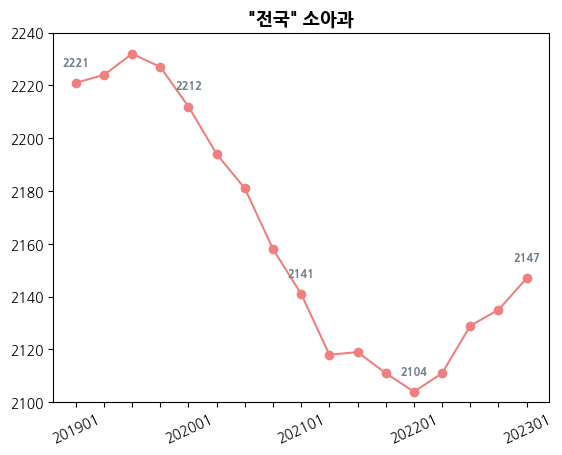

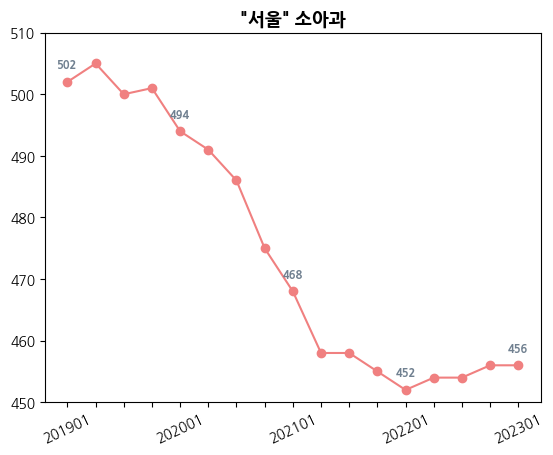

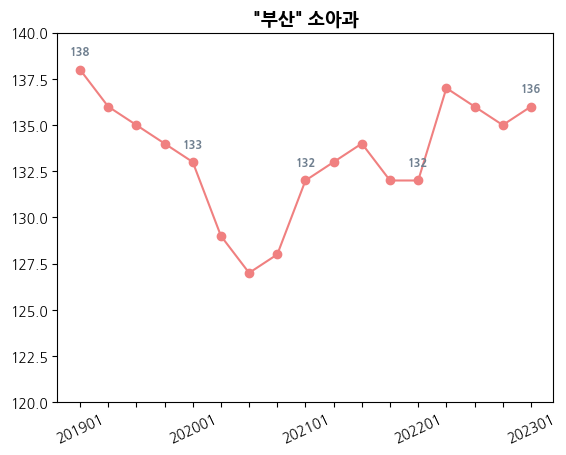

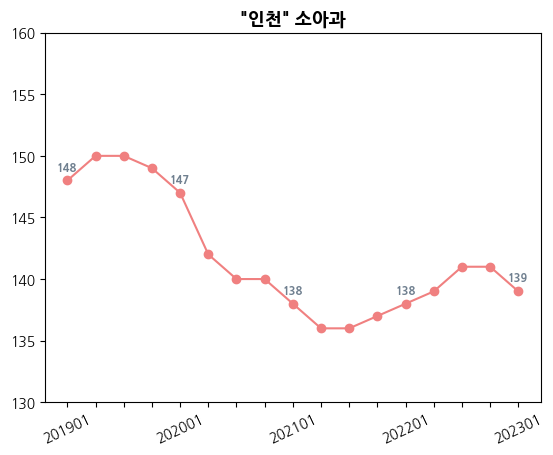

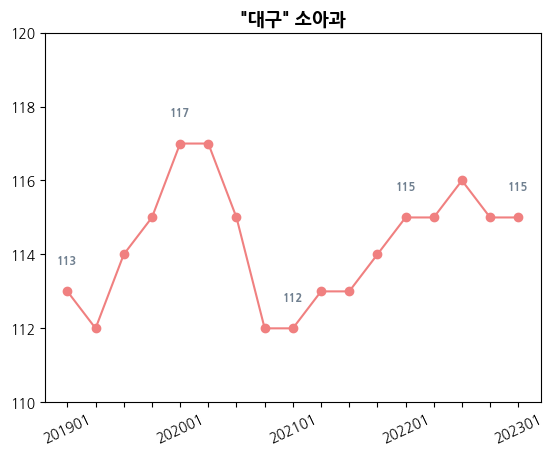

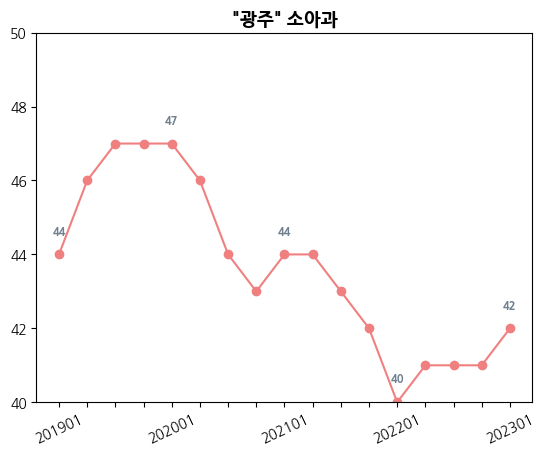

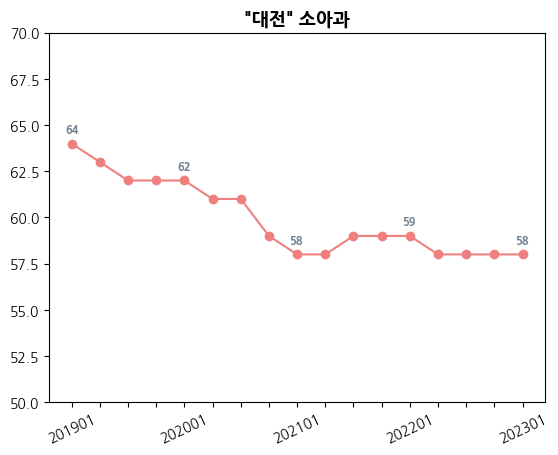

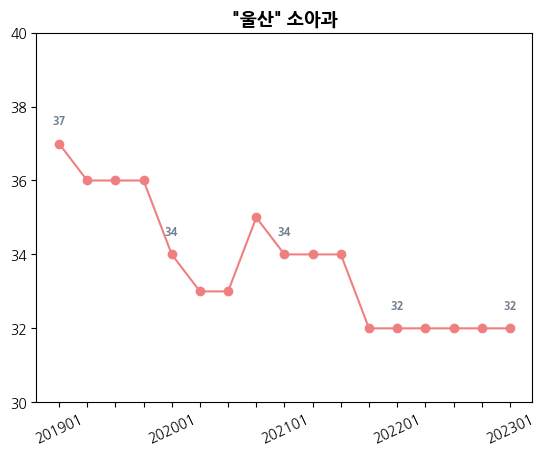

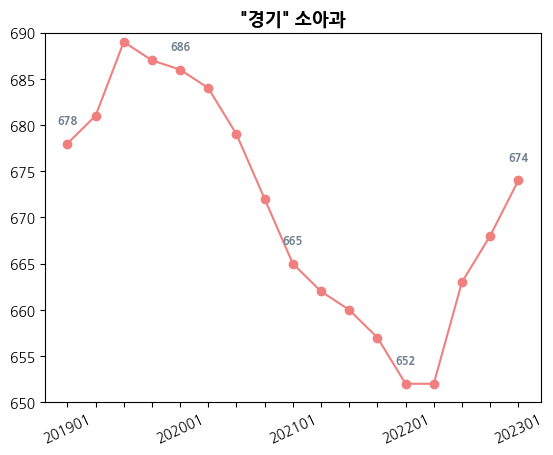

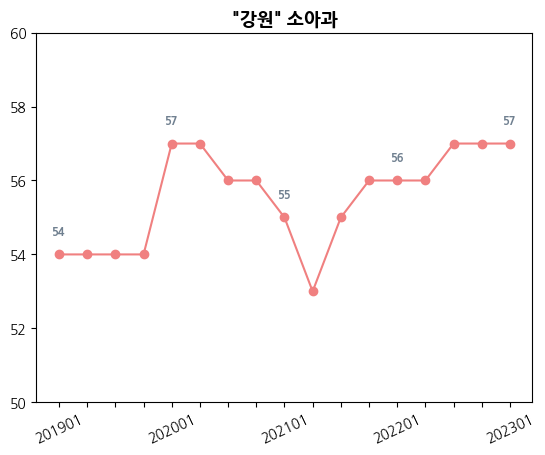

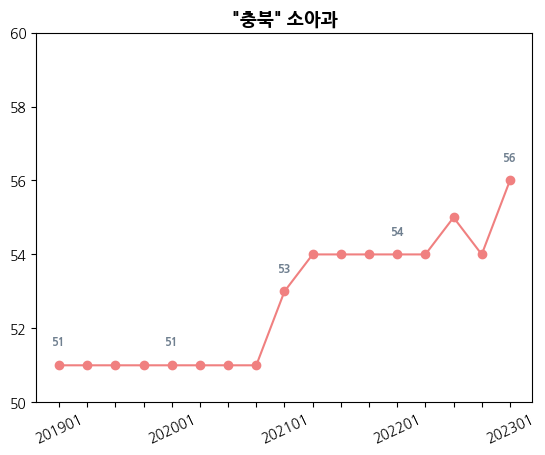

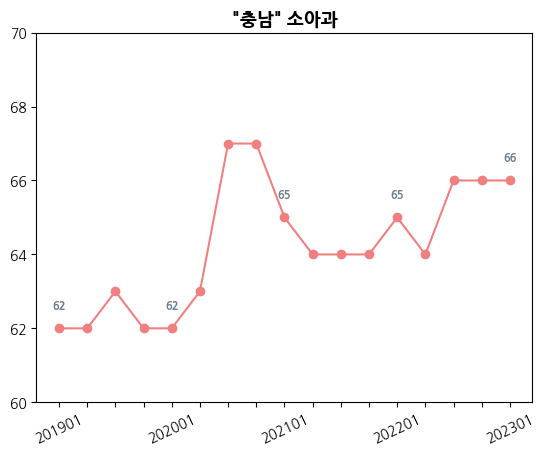

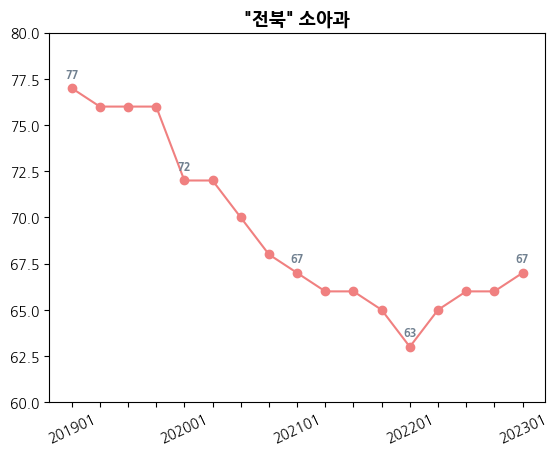

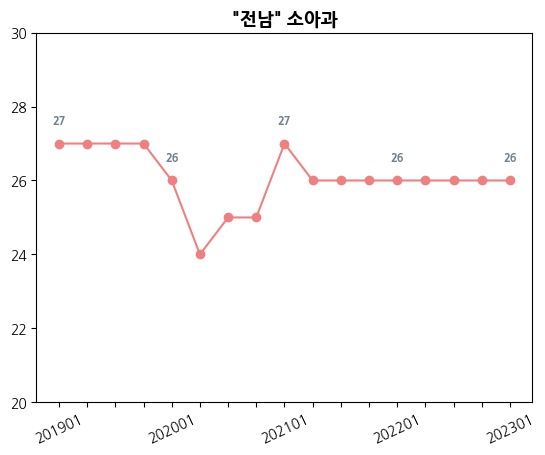

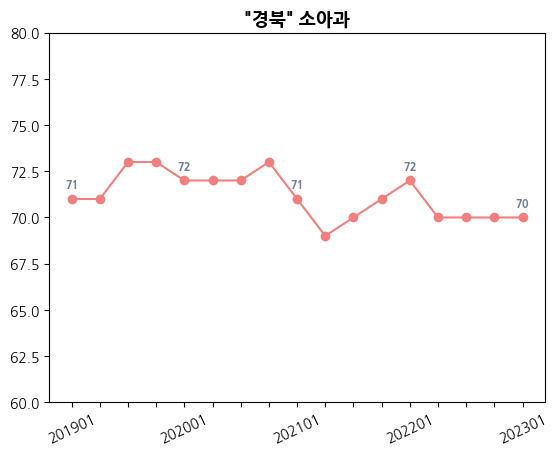

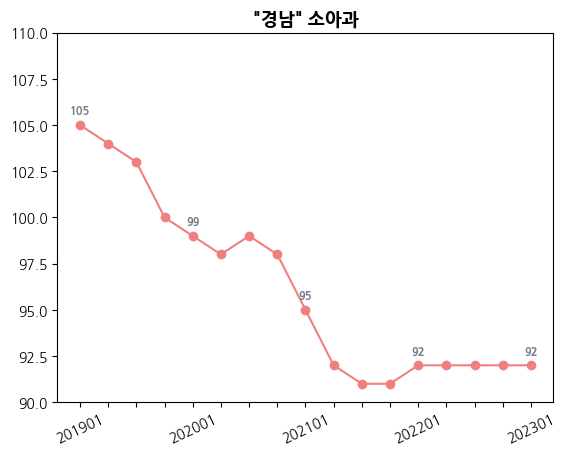

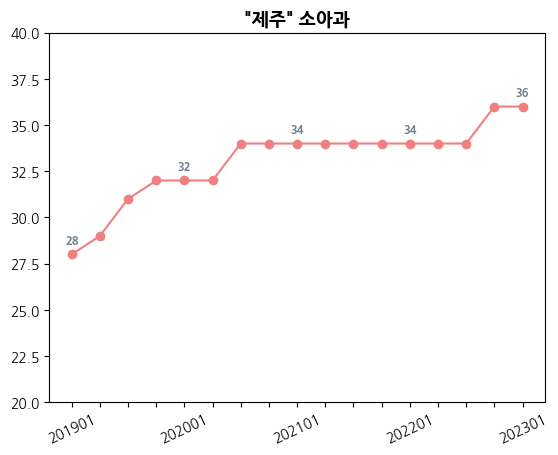

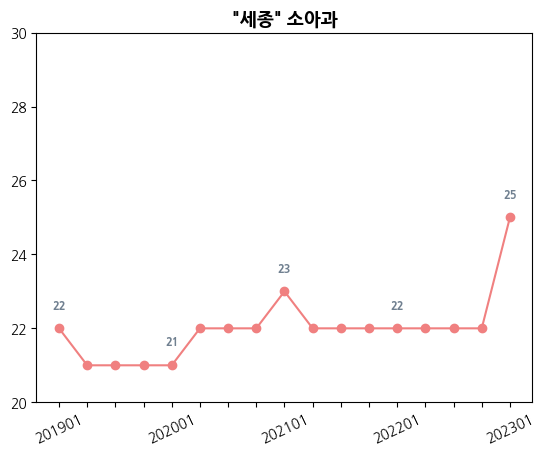

In [3]:
'''
    Visualization_1. 지역별 소아청소년과 현황 그래프
'''

years = ['201901', '', '', '', '202001', '', '', '', '202101', '', '', '', '202201', '', '', '', '202301']
x = np.arange(len(years))
save_path = "./src/image/"

for key in sido_files:
    df = sido_files[key]
    max_score = round(max(df['소아청소년과']) + 5, -1)
    min_score = round(min(df['소아청소년과']) - 5, -1)

    loc = df['시도'][0]
    title = '"' + loc + '" 소아과'
    plt.plot(x, df['소아청소년과'], 'o-', color = 'lightcoral')
    plt.title(title, fontsize = 13, fontweight='bold')
    plt.ylim(min_score, max_score)
    plt.xticks(x, years, rotation=25)

    for i in range(len(df)):
        h_mean = df['소아청소년과'].mean()
        if h_mean >= 1000: alpha = 6
        elif h_mean >= 400: alpha = 2
        elif h_mean >= 100: alpha = 0.7
        else : alpha = 0.5
        if i%4 == 0:
            height = df['소아청소년과'][i]
            plt.text(i, height+alpha, '%.f'%height, ha='center',va = 'bottom', size = 8, color = 'slategrey', fontweight = 'heavy')

    path = save_path + '소아과현황_' + loc + '.png'
    plt.savefig(path)
    plt.show()



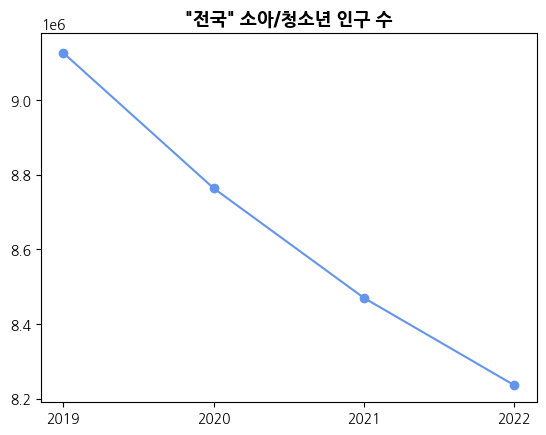

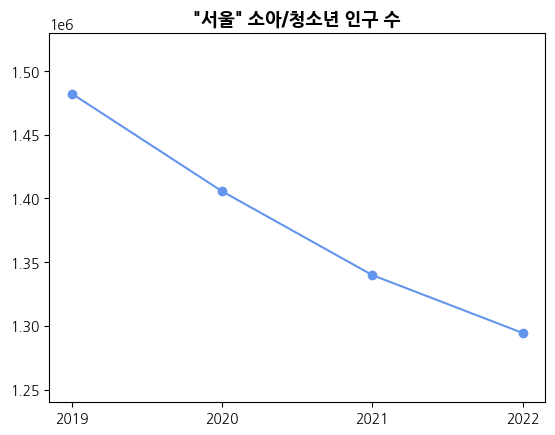

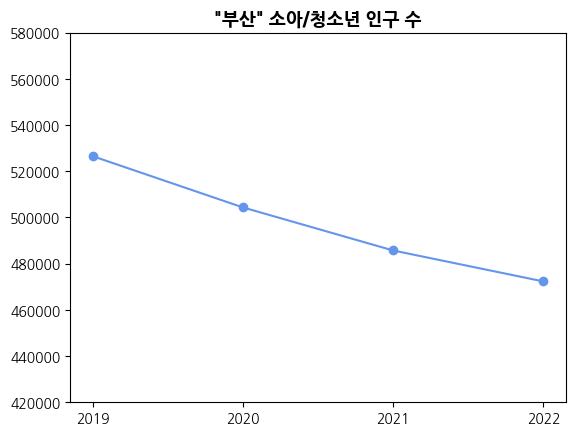

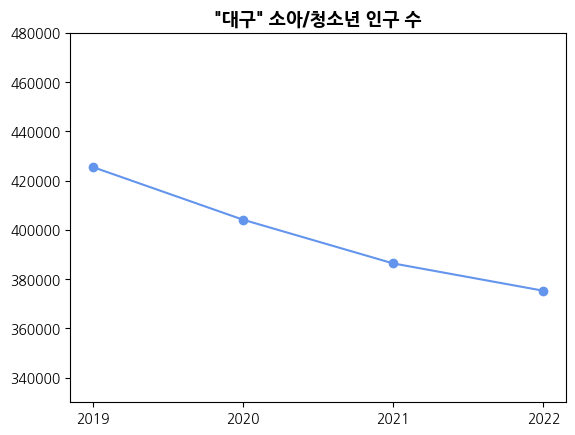

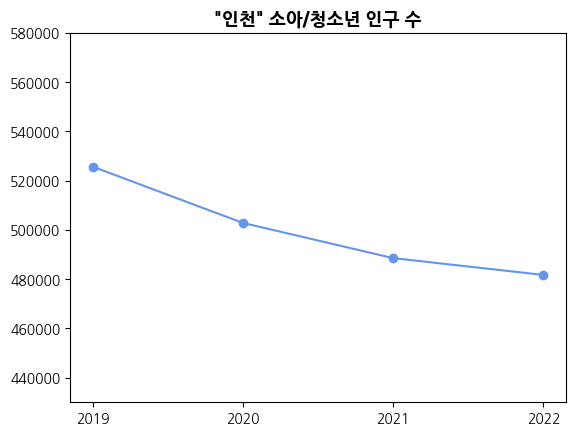

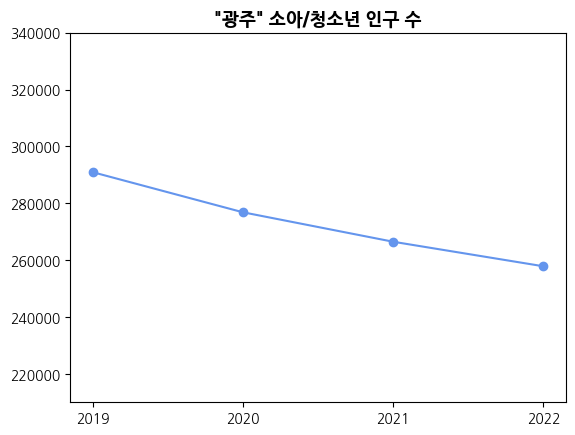

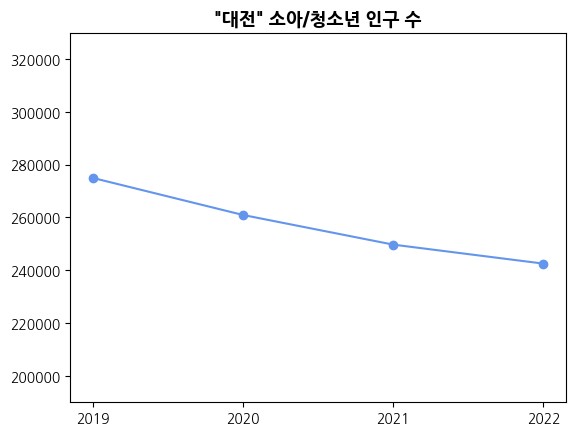

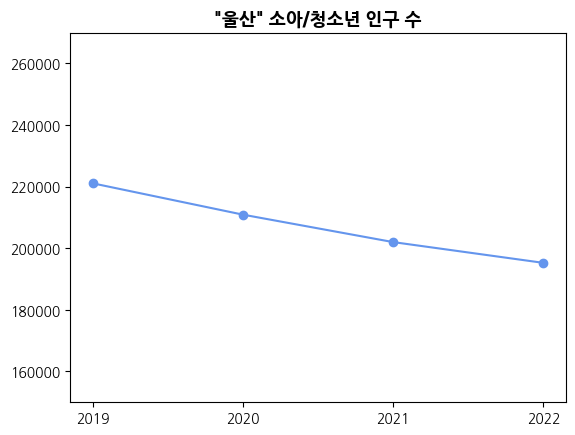

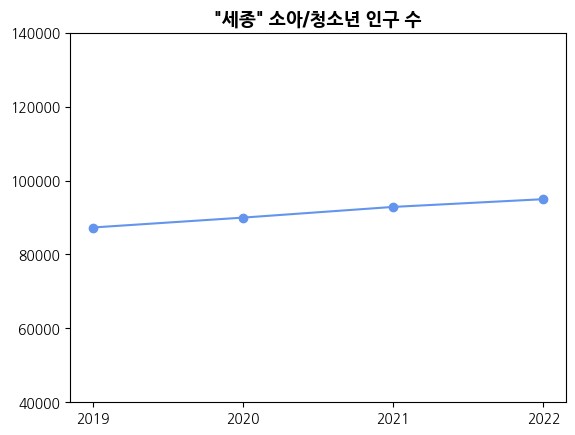

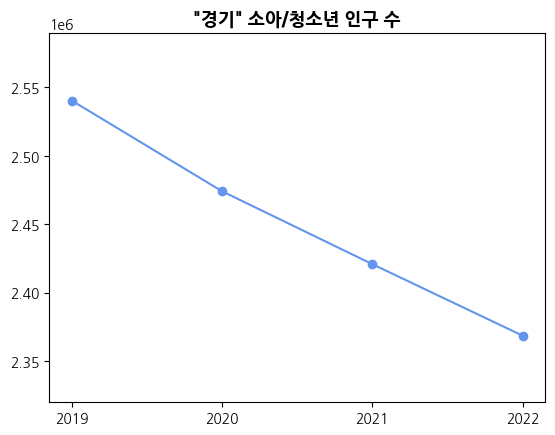

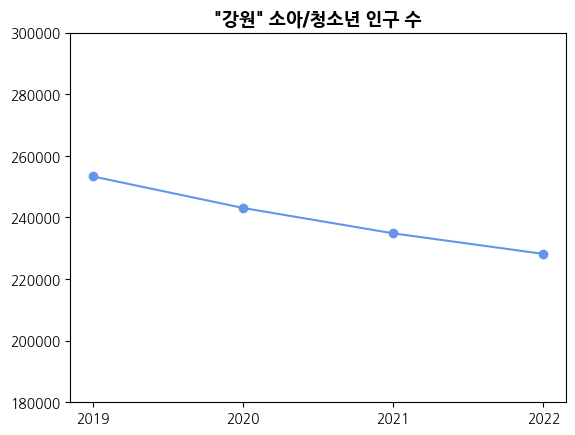

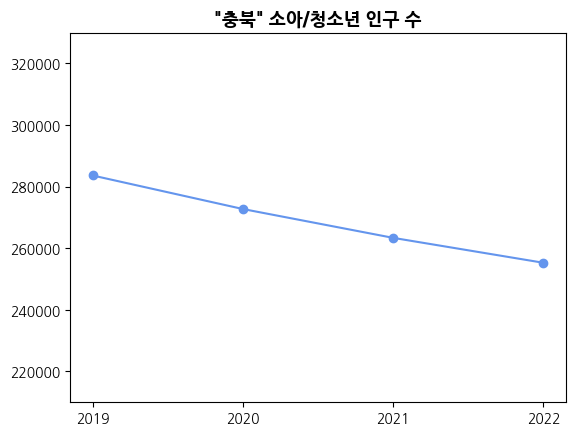

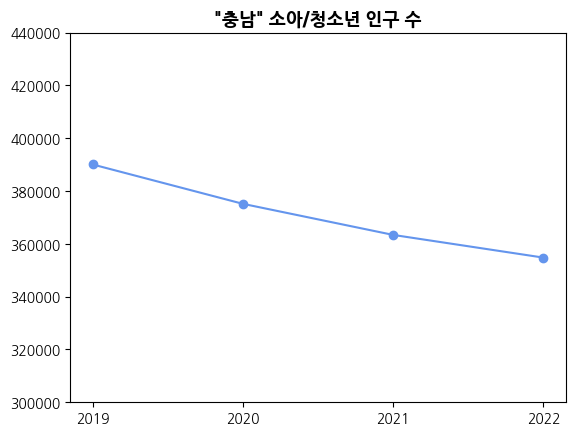

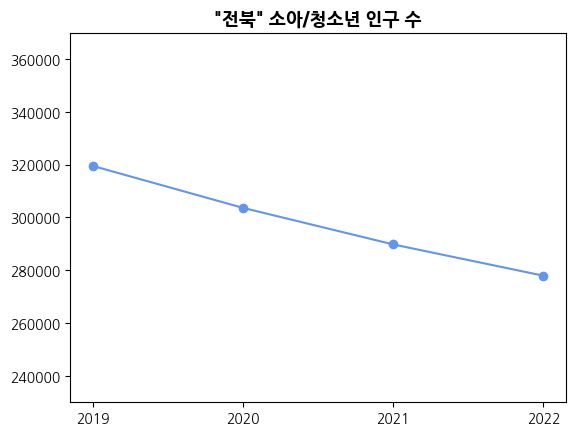

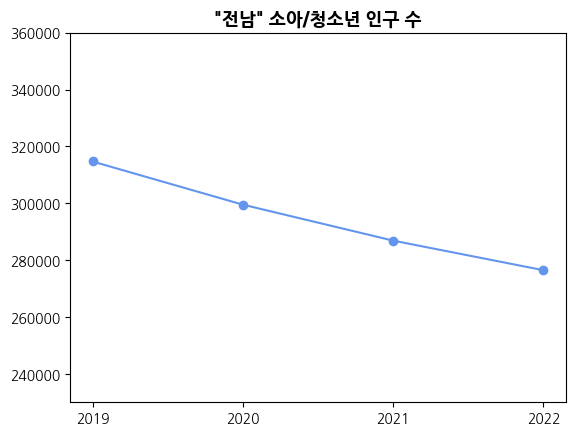

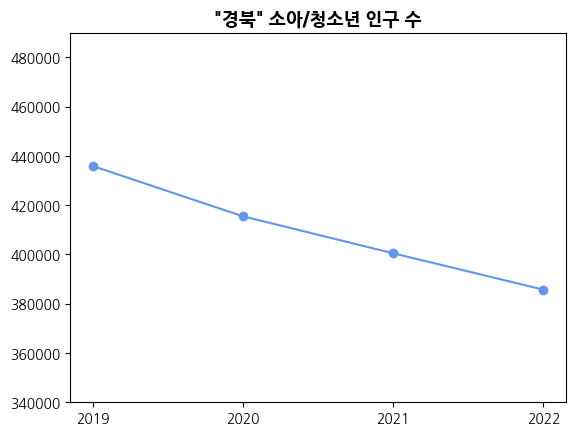

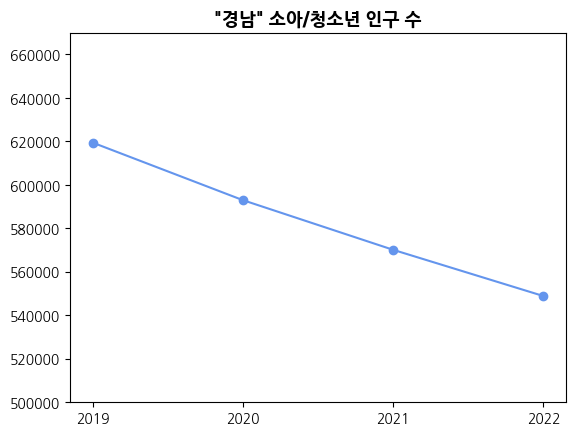

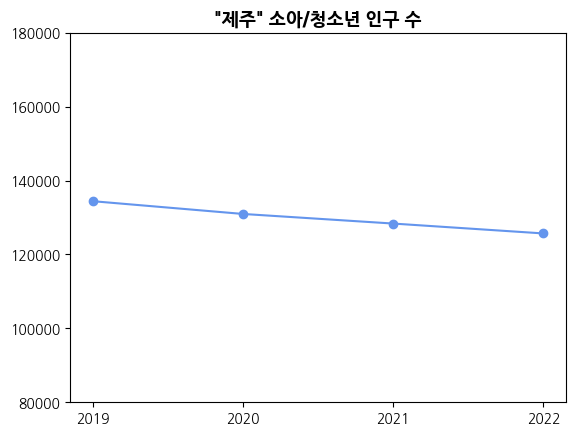

In [4]:

'''
    Visualization_2. 지역별 소아청소년과 인구 그래프
'''
save_path = "./src/image/"
years = ['2019', '2020', '2021', '2022']
x = len(years)

for key in young_popul_local:
    df = young_popul_local[key]
    min_popul = round((min(df['총 인구']))-50000, -4)
    max_popul = round((max(df['총 인구']))+50000, -4)

    title = '"' + key + '" 소아/청소년 인구 수'
    plt.plot(df['총 인구'], 'o-', color = 'cornflowerblue')
    plt.title(title, fontsize = 13, fontweight = 'bold')
    plt.ylim(min_popul, max_popul)
    plt.xticks(years)
    path = save_path + '소아청소년인구_' + key + '.png'
    plt.savefig(path)
    plt.show()
    

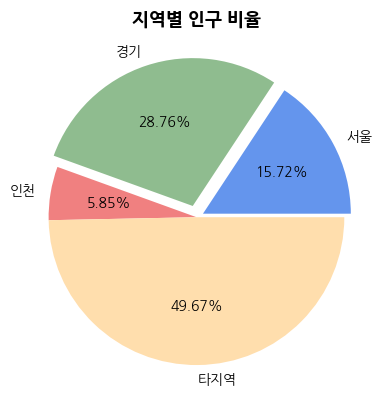

In [5]:
'''
    Visualization_3. 지역별 지역별 소아청소년과 인구 그래프
'''
save_path = "./src/image/"
total = young_popul_2022['총 인구'][0]
seoul = young_popul_2022['총 인구']['서울']
geonggi = young_popul_2022['총 인구']['경기']
incheon = young_popul_2022['총 인구']['인천']
capital_area = seoul + geonggi + incheon

dic = {'서울' : [seoul], '경기' : [geonggi], '인천' : [incheon], '타지역' : [total - capital_area]}
df_popul_2022 = pd.DataFrame(dic, index=['인구']).T
df_popul_2022

x = len(df_popul_2022)
explodes = [0.05, 0.08, 0, 0]
colors = ['cornflowerblue', 'darkseagreen' , 'lightcoral', 'navajowhite']
plt.pie(df_popul_2022['인구'], labels = df_popul_2022.index, autopct='%.2f%%', explode = explodes, colors=colors)
plt.title('지역별 인구 비율', fontsize = 13, fontweight = 'bold')

path = save_path + '2022_지역별 인구 비율.png'
plt.savefig(path)
plt.show()

Ratio

In [6]:
'''
    Data_4. 인구 천 명당 병원 비율 병원 / 인구 * 1000
'''
# hos_pop_ratio  : 지역 별 인구 1000명당 병원 비율
# hos_pop_ratio : 연도 별 지역 별 인구 1000명당 병원 비율


# hos_pop_ratio : 지역 별 인구 1000명당 병원 비율
# 병원 현황 DataFrame 형식 : df_ratio_지역
#                          index = years
#                          columns = 병원수, 총인구, 천 명당 의료기관 비율(%)
#                          ex.) hos_pop_ratio['df_ratio_전국']
hos_pop_ratio = {}
index_labels = ['2019', '2020','2021', '2022']
for sidofile in sido_files:
    sido = '전국' if sidofile.split('_')[1] == '계' else sidofile.split('_')[1]
    name = 'df_ratio_' + sido

    sido_df = sido_files[sidofile]
    sido_df['기준분기'] = sido_df['기준분기'].astype(str)
    hos = sido_df[ sido_df['기준분기'].str.endswith('04')]['소아청소년과'].to_list()
    popul = young_popul_local[sido]['총 인구'].to_list()
    df = pd.DataFrame({'병원수' : hos, '총인구' : popul}, index = index_labels)
    df['천 명당 의료기관 비율(%)'] = round((df['병원수'] / df['총인구']) * 1000 * 100, 2)
    hos_pop_ratio[name] = df

hos_pop_ratio['df_ratio_전국']

# hos_pop_ratio : 연도 별 지역 별 인구 1000명당 병원 비율
# 병원 현황 DataFrame 형식 : df_ratio_연도
#                          index = 지역
#                          columns = 년도_천 명당 의료기관 비율(%)
#                          ex.) hos_pop_ratio_year['df_ratio_2019']
hos_pop_ratio_year = {}
col = '천 명당 의료기관 비율(%)'
ex_key = 'df_ratio_전국'
year_len = len(hos_pop_ratio[ex_key])

# 전국 지역별 비율
for key in hos_pop_ratio:
    local = key.split('_')[-1]
    # 년도별로 뽑아내기
    for i in range(year_len):

        year = hos_pop_ratio[key].index[i]
        name = 'df_ratio_' + year
        col_name = [year + '_' + col]
        ratio = hos_pop_ratio[key].loc[year, col]

        if local == '전국':
            df = pd.DataFrame(ratio, index = [local], columns = col_name)
            hos_pop_ratio_year[name] = df
        else:
            sr = pd.Series(ratio, index = col_name, name = local)
            hos_pop_ratio_year[name] = hos_pop_ratio_year[name].append(sr)


<ipython-input-6-6bf4972a4f57>:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hos_pop_ratio_year[name] = hos_pop_ratio_year[name].append(sr)
<ipython-input-6-6bf4972a4f57>:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hos_pop_ratio_year[name] = hos_pop_ratio_year[name].append(sr)
<ipython-input-6-6bf4972a4f57>:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hos_pop_ratio_year[name] = hos_pop_ratio_year[name].append(sr)
<ipython-input-6-6bf4972a4f57>:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hos_pop_ratio_year[name] = hos_pop_ratio_year[name].append(sr)
<ipython-input-6-6bf4972a4f57>:55: FutureWarning: The frame.append m

Ratio Visualize

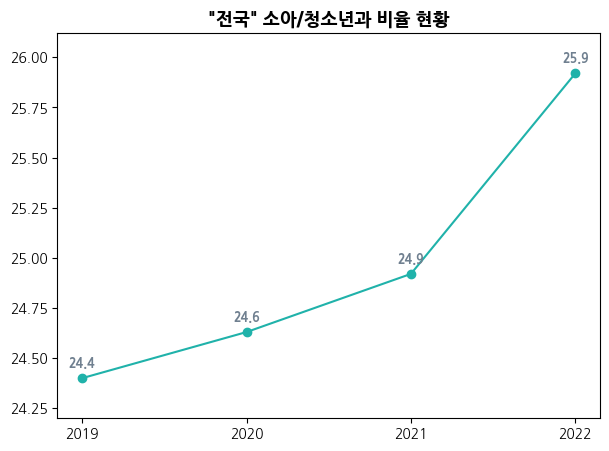

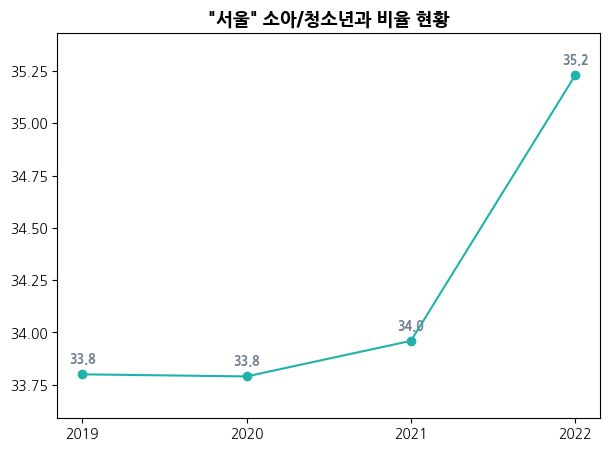

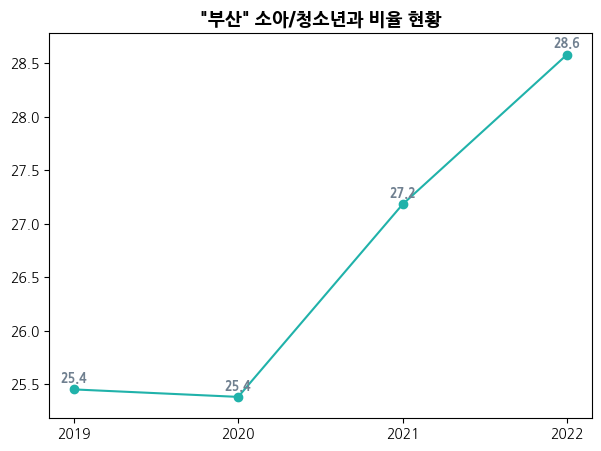

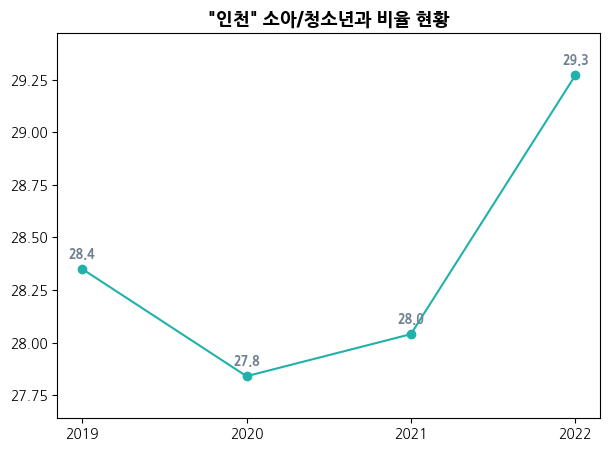

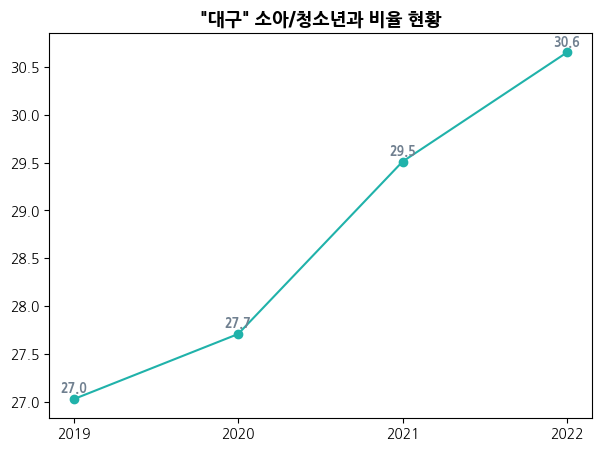

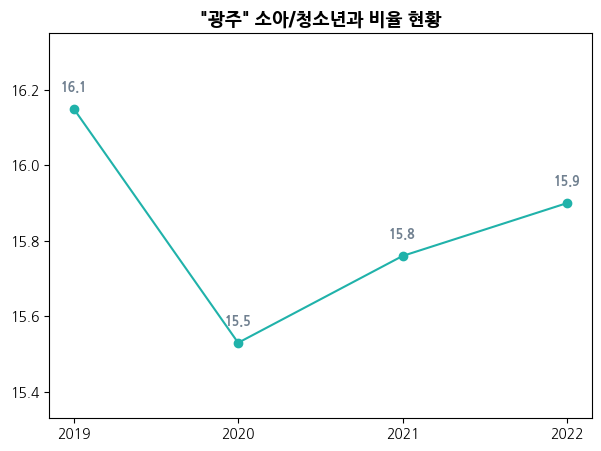

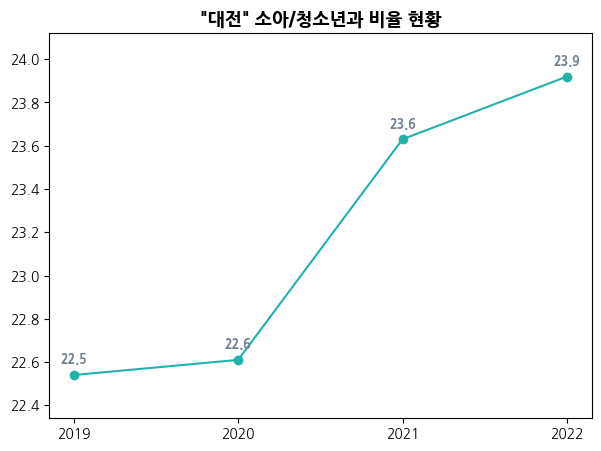

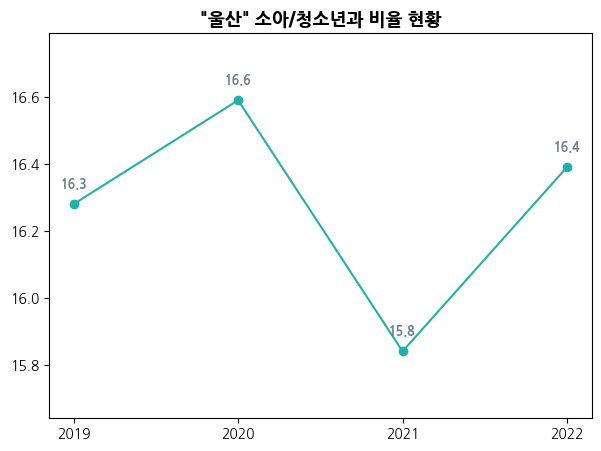

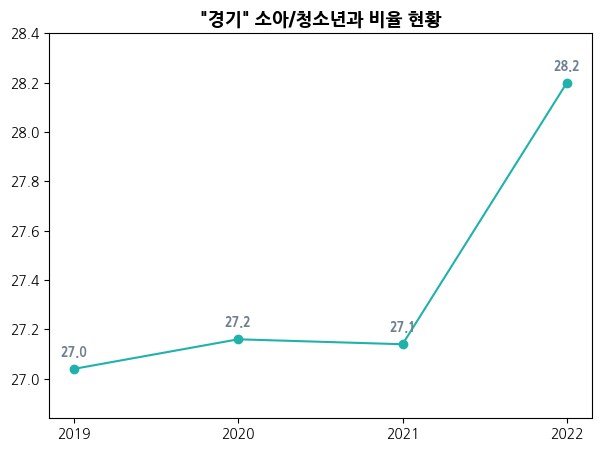

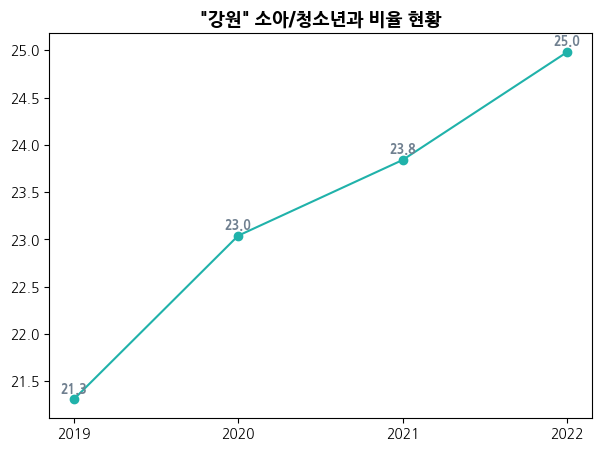

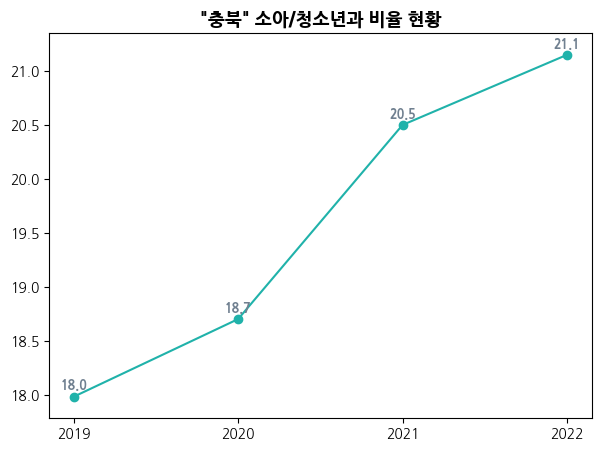

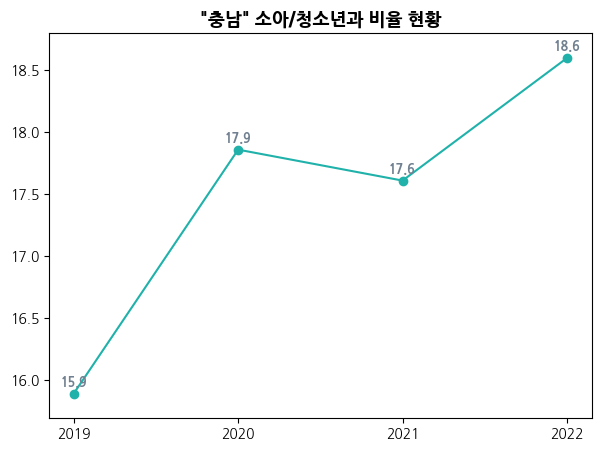

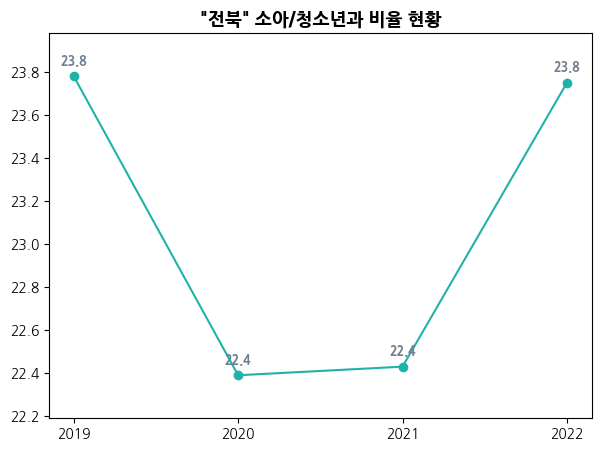

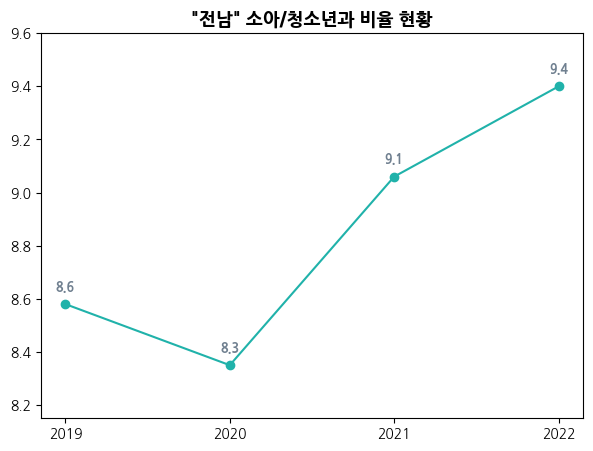

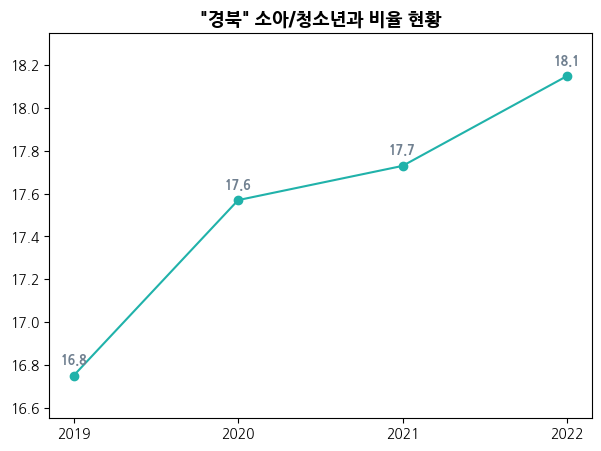

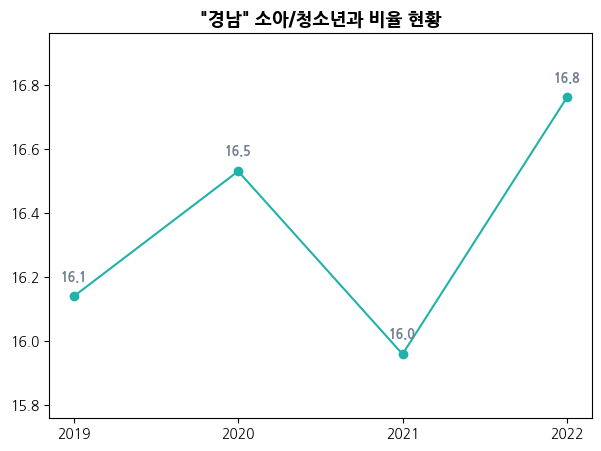

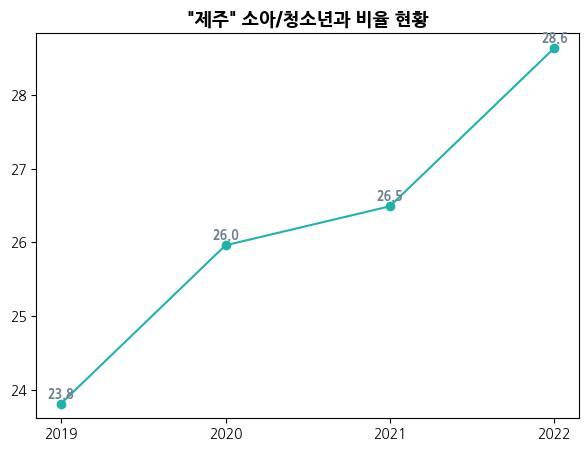

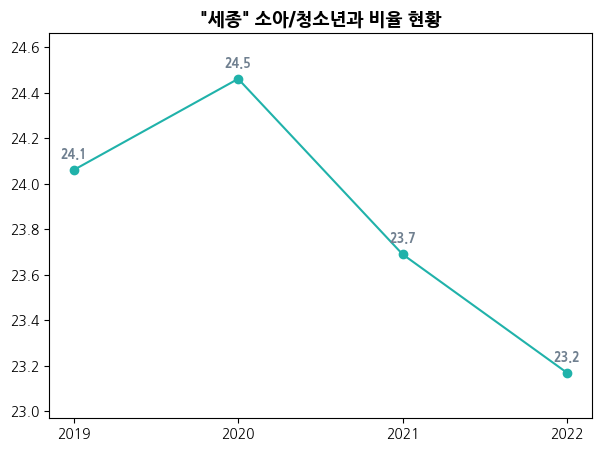

In [7]:
'''
    Visualization_4. 지역별 소아/청소년과 비율 현황
'''
save_path = "./src/image/"
for key in hos_pop_ratio:
    sr = hos_pop_ratio[key].iloc[:, 2]
    min_v = min(sr) - 0.2
    max_v = max(sr) + 0.2
    local = key.split('_')[-1]

    plt.figure(figsize = (7, 5))
    plt.plot(sr, 'o-', color = 'lightseagreen')
    plt.ylim(min_v, max_v)
    title = '"' + local + '" 소아/청소년과 비율 현황'
    plt.title(title, fontsize = 13, fontweight = 'bold')

    for i in range(len(sr)):
        height = sr[i]
        plt.text(sr.index[i], height+0.04, '%.1f'%height, ha='center',va = 'bottom', size = 9, color = 'slategrey', fontweight = 'heavy')
    path = save_path + '소아과비율_' + local + '.png'
    plt.savefig(path)
    plt.show()

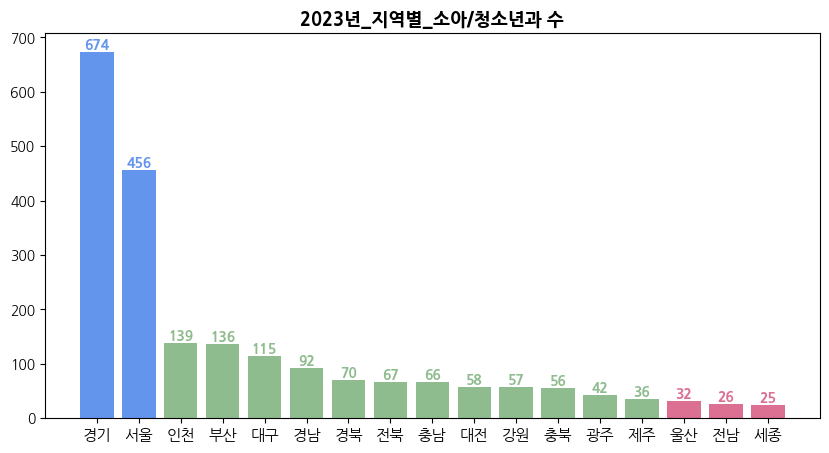

In [8]:
'''
    Visualization_5. 2023 지역별 소아 청소년과 수
'''
save_path = "./src/image/"
df = hos_files[-1][['시도', '소아청소년과']]
df = df.apply(to_numeric)[1:].sort_values(by='소아청소년과', ascending=False)
plt.figure(figsize = (10, 5))
all_locals = list(df.index)
colors = (['cornflowerblue']*2) + (['darkseagreen']*(len(df)-5)) + (['palevioletred']*3)
x = np.arange(len(df))
bar = plt.bar(x, df['소아청소년과'], color = colors)

cnt = 0
for rect in bar:
    if cnt < 2: color = 'cornflowerblue'
    elif cnt > len(bar) - 4 : color = 'palevioletred'
    else : color = 'darkseagreen'

    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height+0.2, '%.f'%height, ha='center', va='bottom', size=10, fontweight = 'heavy', color = color)
    cnt += 1

plt.xticks(x, df['시도'], fontsize = 11)
plt.title('2023년_지역별_소아/청소년과 수', fontsize=13, fontweight= 'bold')

path = save_path + '2023_지역별_소아청소년과_수.png'
plt.savefig(path)
plt.show()

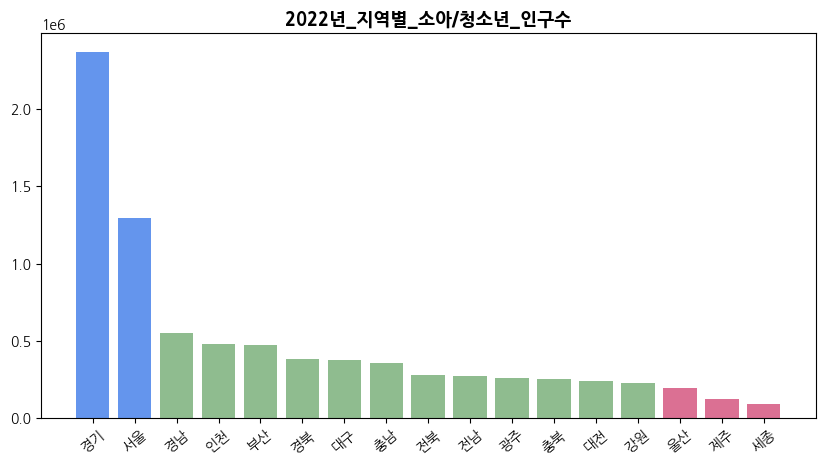

In [9]:
'''
    Visualization_6. 2022 지역별 소아 청소년 인구수
'''
save_path = "./src/image/"
df = young_popul_files[-1].sort_values(by = '총 인구', ascending = False)[1:]
df

plt.figure(figsize = (10, 5))
all_locals = list(df.index)
colors = (['cornflowerblue']*2) + (['darkseagreen']*(len(df)-5)) + (['palevioletred']*3)
x = np.arange(len(df))
plt.bar(x, df['총 인구'], color = colors)
plt.xticks(x, all_locals, rotation = 40)
plt.title('2022년_지역별_소아/청소년_인구수', fontsize=13, fontweight= 'bold')

path = save_path + '2022_지역별_소아청소년_인구수.png'
plt.savefig(path)
plt.show()

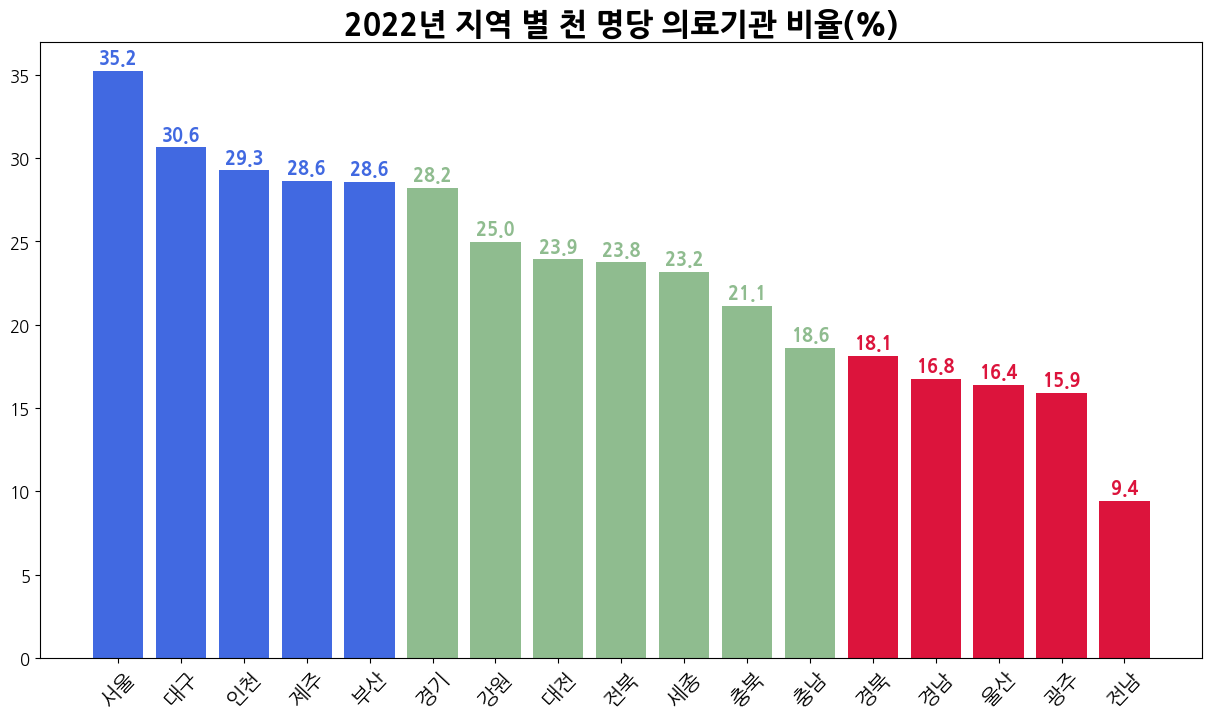

In [10]:
'''
    Visualization_7. 2022 지역별 천명당 의료기관 비율(%)
'''
save_path = "./src/image/"
pie_df = hos_pop_ratio_year['df_ratio_2022'][1:].sort_values(by= '2022_천 명당 의료기관 비율(%)', ascending=False)
plt.figure(figsize = (15, 8))

colors = (['royalblue'] * 5) + (['darkseagreen'] * (len(pie_df)-10)) + (['crimson']*5)
x = np.arange(len(pie_df['2022_천 명당 의료기관 비율(%)']))
bar = plt.bar(x, pie_df['2022_천 명당 의료기관 비율(%)'].to_list(), color = colors)
plt.xticks(x, pie_df.index, rotation = 47, fontsize = 15)
plt.yticks(fontsize = 12)
plt.title('2022년 지역 별 천 명당 의료기관 비율(%)', fontsize=22, fontweight = 'bold')

cnt = 0
for rect in bar:
    if cnt < 5 : color = 'royalblue'
    elif cnt > len(bar) - 6 : color = 'crimson'
    else : color = 'darkseagreen'

    height = rect.get_height()
    
    plt.text(rect.get_x() + rect.get_width()/2.0, height+0.2, '%.1f'%height, ha='center', va='bottom', size=13, fontweight = 'heavy', color = color)
    cnt += 1

path = save_path + '2022_지역별_의료기관_비율.png'
plt.savefig(path)
plt.show()

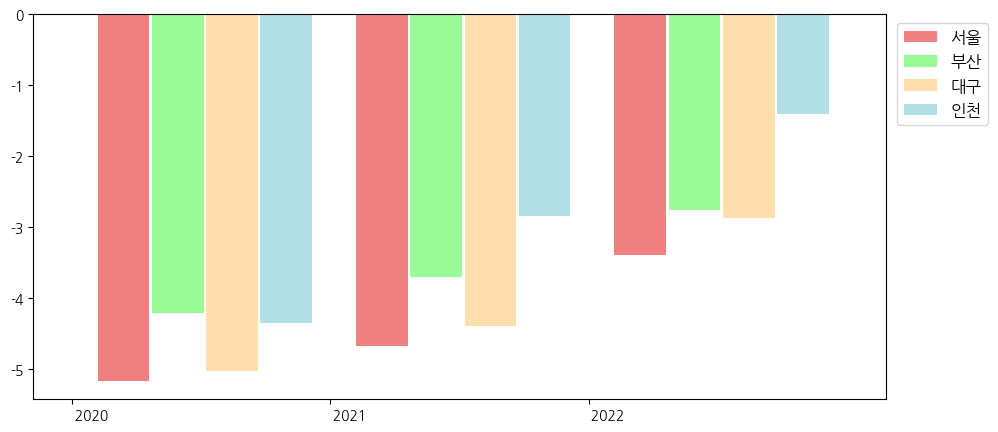

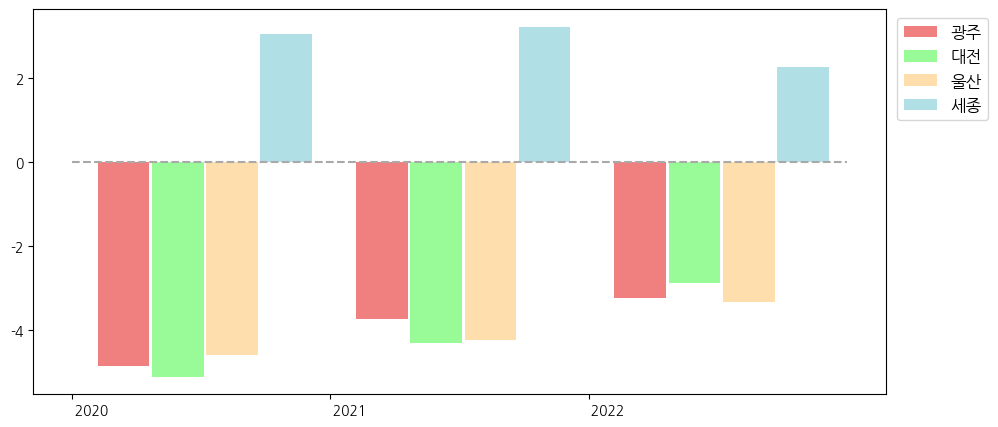

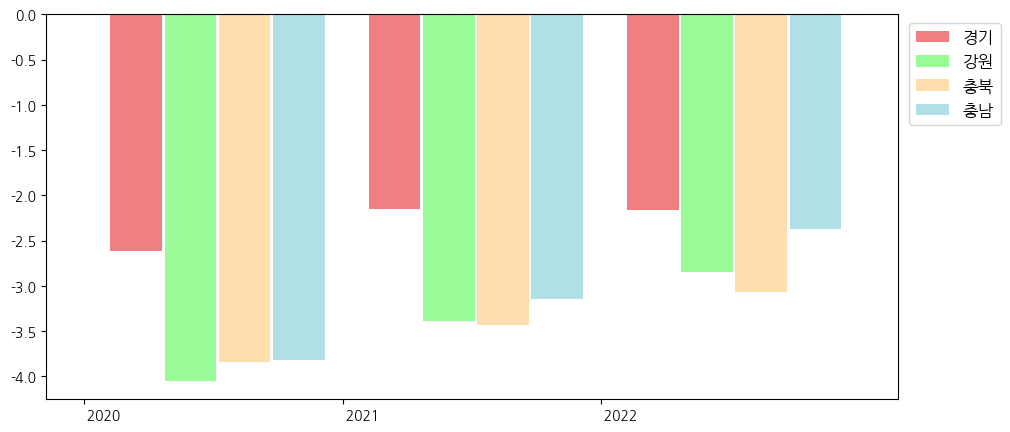

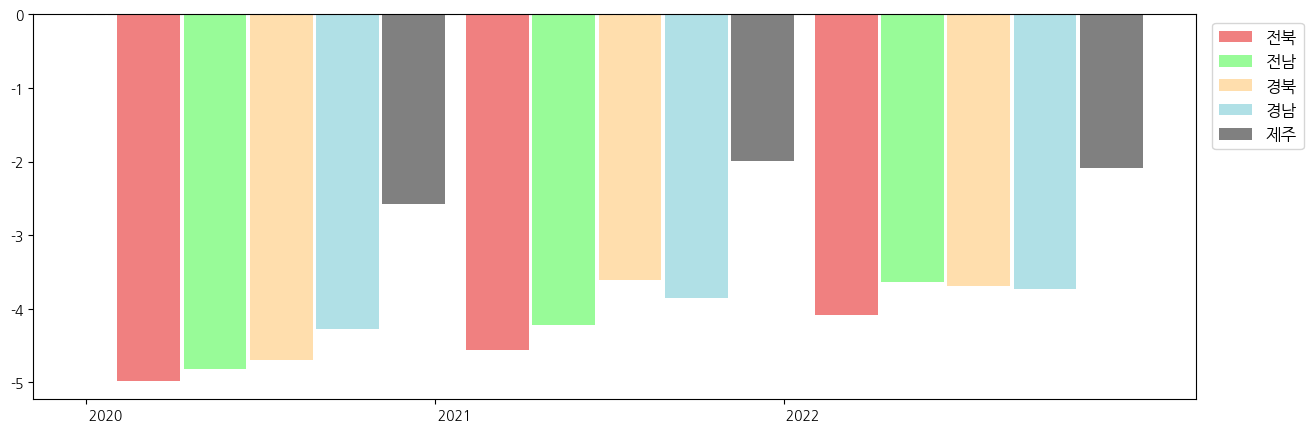

In [11]:
'''
    Visualization_8. 지역별 2020 - 2022 인구 증감률 그래프
'''
save_path = "./src/image/"
all_locals = list(young_popul_local.keys())
years = list(young_popul_local[all_locals[0]].index)
local_len = len(all_locals)-1 if '전국' in all_locals else len(all_locals)

if local_len//4 >= 1:
    nums = [4 for _ in range((local_len//4)+1)]
    if local_len%4 == 1:
        nums = nums[:-1]
        nums[-1] += 1
    elif local_len%4 == 2:
        for i in reversed(range(-2, 0)):
            nums[i] -= 1
    elif local_len%4 == 3:
        nums[-1] -= 1
    else:
        nums = nums[:-1]
else:
    nums = [local_len]

        
if '전국' in all_locals: all_locals.remove('전국')
locals = []
cnt = 0
for n in nums:
    locals.append(all_locals[cnt:cnt+n])
    cnt += n

year = years[1:]
for locals_list in locals:
    data = []
    for local in locals_list:
        sr = young_popul_local[local]['총 인구']
        sr_list = []
        for i in range(len(sr)-1):
            a = round(((sr[i+1] - sr[i])/sr[i])*100, 2)
            sr_list.append(a)
        data.append(sr_list)

    data_dict = {x:y for x, y in zip(locals_list, data)}

    df = pd.DataFrame(data_dict, index=year)

    if len(locals_list) == 4:
        plt.figure(figsize=(11, 5))
        bar_width = 0.2; anchor = 1.13
    elif len(locals_list) == 5:
        plt.figure(figsize=(15, 5))
        bar_width = 0.18; anchor =1.1
    
    x = np.arange(len(year))
    colors = ['lightcoral', 'palegreen', 'navajowhite', 'powderblue', 'grey']

    for i in range(len(locals_list)):
        loc = locals_list[i]
        plt.bar(x + (i+1)*bar_width + (0.01*i), df[loc], bar_width, label = loc, color = colors[i])
    plt.plot([0, 0, 0, 0], '--', color='darkgrey')
    plt.legend(loc='upper right', bbox_to_anchor=(anchor, 1), fontsize = 12)
    xticks = []
    for y in year:
        xticks.append(f'          {y}')
    plt.xticks(x, [y for y in xticks])
    path = save_path + f'지역별증감그래프_{locals.index(locals_list)}.png'
    plt.savefig(path)
    plt.show()